# Autoencoder Baseline for DCASE‑Inspired Anomalous Sound Detection


In [4]:
# Install dependencies (uncomment if needed)
# !pip install torch torchvision torchaudio librosa tqdm scikit-learn

In [5]:
import os, glob
import numpy as np
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
import librosa, librosa.display
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import random

In [ ]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 4090


## DATA Examination

In [7]:
TRAIN_DIR = 'DATA/dev_data/dev_data/slider/train'
TEST_DIR = 'DATA/dev_data/dev_data/slider/test'
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  '*.wav')))
print('Train samples:', len(train_files))
print('Test  samples:', len(test_files))
print('First 3 train files:', train_files[:3])

def get_duration(path):
    return librosa.get_duration(path=path)
total_sec = sum(get_duration(f) for f in tqdm(train_files, desc='calc duration'))
print(f"Total train duration: {total_sec/3600:.2f} h")

Train samples: 2370
Test  samples: 1101
First 3 train files: ['DATA/dev_data/dev_data/slider/train\\normal_id_00_00000000.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000001.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000002.wav']


calc duration:   0%|          | 0/2370 [00:00<?, ?it/s]

calc duration: 100%|██████████| 2370/2370 [00:01<00:00, 1571.69it/s]

Total train duration: 6.58 h


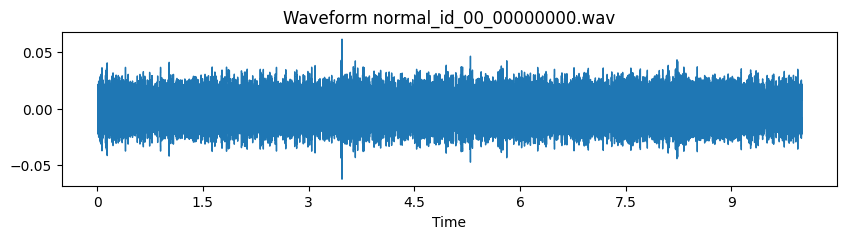

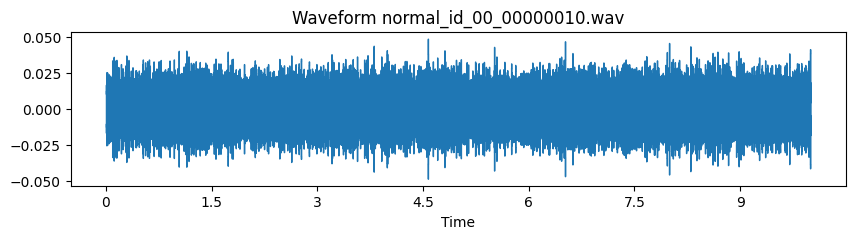

In [8]:
# Plot waveform examples
for idx in [0, 10]:
    y, sr = librosa.load(train_files[idx], sr=None)
    plt.figure(figsize=(10,2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform {os.path.basename(train_files[idx])}")
    plt.show()

## Audio → log‑mel conversion

In [9]:
SAMPLE_RATE = 16000
N_MELS = 64
HOP = 512
FRAMES = 128

def audio_to_logmel(path, sr=SAMPLE_RATE):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP)
    logmel = librosa.power_to_db(mel)

    # Frame-wise pad/trim
    logmel = logmel.T  # [Time, Mel]
    if logmel.shape[0] < FRAMES:
        pad = FRAMES - logmel.shape[0]
        logmel = np.pad(logmel, ((0, pad), (0, 0)))
    else:
        logmel = logmel[:FRAMES]

    # Normalize
    logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
    return logmel



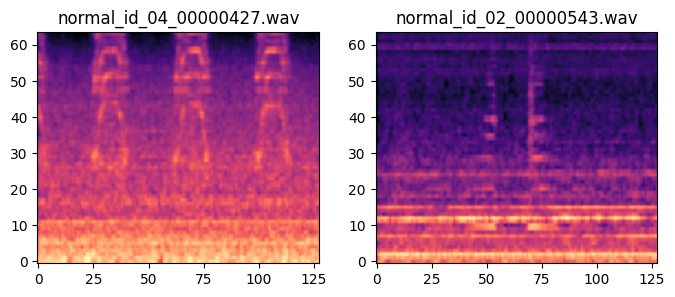

In [10]:
# Show spectrograms of random samples
fig, axes = plt.subplots(1,2, figsize=(8,3))
for ax, p in zip(axes, random.sample(train_files, 2)):
    lm = audio_to_logmel(p)
    ax.imshow(lm.T, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(os.path.basename(p))
plt.show()

## Offline preprocess to `.npy`

In [11]:
PREP_DIR = 'DATA/preprocessed'
RAW_DIR = 'DATA/dev_data/dev_data/slider'

os.makedirs(f'{PREP_DIR}/train', exist_ok=True)
os.makedirs(f'{PREP_DIR}/test',  exist_ok=True)

for split in ['train','test']:
    src = os.path.join(RAW_DIR, split)
    dst = os.path.join(PREP_DIR, split)
    for wav in tqdm(glob.glob(f'{src}/*.wav'), desc=f'Prep {split}', leave=False):
        out_npy = os.path.join(dst, os.path.basename(wav).replace('.wav','.npy'))
        if os.path.exists(out_npy):
            continue
        np.save(out_npy, audio_to_logmel(wav))


## Dataset & DataLoader

In [12]:
class NPYSoundDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # [frames, mels]
        x = torch.tensor(arr, dtype=torch.float32).flatten()
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label

BATCH_SIZE = 2048
train_ds = NPYSoundDataset(f'{PREP_DIR}/train')
test_ds  = NPYSoundDataset(f'{PREP_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Fully‑connected Autoencoder

In [26]:
INPUT_DIM = FRAMES * N_MELS
HIDDEN = 1024

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(INPUT_DIM, HIDDEN), nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(HIDDEN, INPUT_DIM), nn.ReLU())
    def forward(self, x): return self.dec(self.enc(x))

model = AE().to(DEVICE)
print(model)

AE(
  (enc): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=1024, out_features=8192, bias=True)
    (1): ReLU()
  )
)


## Training Loop

In [27]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
crit = nn.MSELoss()
EPOCHS = 500

# Scheduler + early-stop params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=10, 
)
patience = 20       # how many epochs to wait for loss improvement
min_delta = 1e-5    # minimum change in loss to count as “improved”

history = []
best_loss = float('inf')
stale_epochs = 0

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}', leave=False):
        x = x.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)

    avg = total_loss / len(train_ds)
    history.append(avg)
    print(f'Epoch {ep:2d} loss={avg:.6f}')

    # step the LR scheduler on the validation metric (here train loss)
    scheduler.step(avg)

    # early-stopping check
    if best_loss - avg > min_delta:
        best_loss = avg
        stale_epochs = 0
        print(f"  ↳ Improvement detected (new best_loss={best_loss:.6f}). Patience reset.")
    else:
        stale_epochs += 1
        print(f"  ↳ No significant improvement for {stale_epochs}/{patience} epochs.")
        if stale_epochs >= patience:
            print(f"Early stopping at epoch {ep}: no loss decrease >{min_delta} for {patience} epochs.")
            break


Epoch  1 loss=0.222861
  ↳ Improvement detected (new best_loss=0.222861). Patience reset.


Epoch  2 loss=0.167395
  ↳ Improvement detected (new best_loss=0.167395). Patience reset.


Epoch  3 loss=0.146697
  ↳ Improvement detected (new best_loss=0.146697). Patience reset.


Epoch  4 loss=0.124588
  ↳ Improvement detected (new best_loss=0.124588). Patience reset.


Epoch  5 loss=0.112505
  ↳ Improvement detected (new best_loss=0.112505). Patience reset.


Epoch  6 loss=0.103263
  ↳ Improvement detected (new best_loss=0.103263). Patience reset.


Epoch  7 loss=0.097379
  ↳ Improvement detected (new best_loss=0.097379). Patience reset.


Epoch  8 loss=0.092723
  ↳ Improvement detected (new best_loss=0.092723). Patience reset.


Epoch  9 loss=0.088744
  ↳ Improvement detected (new best_loss=0.088744). Patience reset.


Epoch 10 loss=0.085591
  ↳ Improvement detected (new best_loss=0.085591). Patience reset.


Epoch 11 loss=0.083052
  ↳ Improvement detected (new best_loss=0.083052). Patience reset.


Epoch 12 loss=0.080938
  ↳ Improvement detected (new best_loss=0.080938). Patience reset.


Epoch 13 loss=0.079122
  ↳ Improvement detected (new best_loss=0.079122). Patience reset.


Epoch 14 loss=0.077637
  ↳ Improvement detected (new best_loss=0.077637). Patience reset.


Epoch 15 loss=0.076336
  ↳ Improvement detected (new best_loss=0.076336). Patience reset.


Epoch 16 loss=0.075256
  ↳ Improvement detected (new best_loss=0.075256). Patience reset.


Epoch 17 loss=0.074344
  ↳ Improvement detected (new best_loss=0.074344). Patience reset.


Epoch 18 loss=0.073499
  ↳ Improvement detected (new best_loss=0.073499). Patience reset.


Epoch 19 loss=0.072803
  ↳ Improvement detected (new best_loss=0.072803). Patience reset.


Epoch 20 loss=0.072184
  ↳ Improvement detected (new best_loss=0.072184). Patience reset.


Epoch 21 loss=0.071607
  ↳ Improvement detected (new best_loss=0.071607). Patience reset.


Epoch 22 loss=0.071076
  ↳ Improvement detected (new best_loss=0.071076). Patience reset.


Epoch 23 loss=0.070580
  ↳ Improvement detected (new best_loss=0.070580). Patience reset.


Epoch 24 loss=0.070115
  ↳ Improvement detected (new best_loss=0.070115). Patience reset.


Epoch 25 loss=0.069688
  ↳ Improvement detected (new best_loss=0.069688). Patience reset.


Epoch 26 loss=0.069298
  ↳ Improvement detected (new best_loss=0.069298). Patience reset.


Epoch 27 loss=0.068973
  ↳ Improvement detected (new best_loss=0.068973). Patience reset.


Epoch 28 loss=0.068734
  ↳ Improvement detected (new best_loss=0.068734). Patience reset.


Epoch 29 loss=0.068549
  ↳ Improvement detected (new best_loss=0.068549). Patience reset.


Epoch 30 loss=0.068415
  ↳ Improvement detected (new best_loss=0.068415). Patience reset.


Epoch 31 loss=0.068288
  ↳ Improvement detected (new best_loss=0.068288). Patience reset.


Epoch 32 loss=0.068174
  ↳ Improvement detected (new best_loss=0.068174). Patience reset.


Epoch 33 loss=0.068050
  ↳ Improvement detected (new best_loss=0.068050). Patience reset.


Epoch 34 loss=0.067914
  ↳ Improvement detected (new best_loss=0.067914). Patience reset.


Epoch 35 loss=0.067796
  ↳ Improvement detected (new best_loss=0.067796). Patience reset.


Epoch 36 loss=0.067689
  ↳ Improvement detected (new best_loss=0.067689). Patience reset.


Epoch 37 loss=0.067584
  ↳ Improvement detected (new best_loss=0.067584). Patience reset.


Epoch 38 loss=0.067493
  ↳ Improvement detected (new best_loss=0.067493). Patience reset.


Epoch 39 loss=0.067397
  ↳ Improvement detected (new best_loss=0.067397). Patience reset.


Epoch 40 loss=0.067302
  ↳ Improvement detected (new best_loss=0.067302). Patience reset.


Epoch 41 loss=0.067207
  ↳ Improvement detected (new best_loss=0.067207). Patience reset.


Epoch 42 loss=0.067118
  ↳ Improvement detected (new best_loss=0.067118). Patience reset.


Epoch 43 loss=0.067033
  ↳ Improvement detected (new best_loss=0.067033). Patience reset.


Epoch 44 loss=0.066963
  ↳ Improvement detected (new best_loss=0.066963). Patience reset.


Epoch 45 loss=0.066909
  ↳ Improvement detected (new best_loss=0.066909). Patience reset.


Epoch 46 loss=0.066864
  ↳ Improvement detected (new best_loss=0.066864). Patience reset.


Epoch 47 loss=0.066820
  ↳ Improvement detected (new best_loss=0.066820). Patience reset.


Epoch 48 loss=0.066767
  ↳ Improvement detected (new best_loss=0.066767). Patience reset.


Epoch 49 loss=0.066707
  ↳ Improvement detected (new best_loss=0.066707). Patience reset.


Epoch 50 loss=0.066616
  ↳ Improvement detected (new best_loss=0.066616). Patience reset.


Epoch 51 loss=0.066498
  ↳ Improvement detected (new best_loss=0.066498). Patience reset.


Epoch 52 loss=0.066358
  ↳ Improvement detected (new best_loss=0.066358). Patience reset.


Epoch 53 loss=0.066194
  ↳ Improvement detected (new best_loss=0.066194). Patience reset.


Epoch 54 loss=0.066019
  ↳ Improvement detected (new best_loss=0.066019). Patience reset.


Epoch 55 loss=0.065854
  ↳ Improvement detected (new best_loss=0.065854). Patience reset.


Epoch 56 loss=0.065689
  ↳ Improvement detected (new best_loss=0.065689). Patience reset.


Epoch 57 loss=0.065535
  ↳ Improvement detected (new best_loss=0.065535). Patience reset.


Epoch 58 loss=0.065395
  ↳ Improvement detected (new best_loss=0.065395). Patience reset.


Epoch 59 loss=0.065283
  ↳ Improvement detected (new best_loss=0.065283). Patience reset.


Epoch 60 loss=0.065184
  ↳ Improvement detected (new best_loss=0.065184). Patience reset.


Epoch 61 loss=0.065092
  ↳ Improvement detected (new best_loss=0.065092). Patience reset.


Epoch 62 loss=0.064999
  ↳ Improvement detected (new best_loss=0.064999). Patience reset.


Epoch 63 loss=0.064903
  ↳ Improvement detected (new best_loss=0.064903). Patience reset.


Epoch 64 loss=0.064786
  ↳ Improvement detected (new best_loss=0.064786). Patience reset.


Epoch 65 loss=0.064663
  ↳ Improvement detected (new best_loss=0.064663). Patience reset.


Epoch 66 loss=0.064538
  ↳ Improvement detected (new best_loss=0.064538). Patience reset.


Epoch 67 loss=0.064413
  ↳ Improvement detected (new best_loss=0.064413). Patience reset.


Epoch 68 loss=0.064285
  ↳ Improvement detected (new best_loss=0.064285). Patience reset.


Epoch 69 loss=0.064155
  ↳ Improvement detected (new best_loss=0.064155). Patience reset.


Epoch 70 loss=0.064041
  ↳ Improvement detected (new best_loss=0.064041). Patience reset.


Epoch 71 loss=0.063934
  ↳ Improvement detected (new best_loss=0.063934). Patience reset.


Epoch 72 loss=0.063810
  ↳ Improvement detected (new best_loss=0.063810). Patience reset.


Epoch 73 loss=0.063663
  ↳ Improvement detected (new best_loss=0.063663). Patience reset.


Epoch 74 loss=0.063507
  ↳ Improvement detected (new best_loss=0.063507). Patience reset.


Epoch 75 loss=0.063323
  ↳ Improvement detected (new best_loss=0.063323). Patience reset.


Epoch 76 loss=0.063137
  ↳ Improvement detected (new best_loss=0.063137). Patience reset.


Epoch 77 loss=0.062950
  ↳ Improvement detected (new best_loss=0.062950). Patience reset.


Epoch 78 loss=0.062795
  ↳ Improvement detected (new best_loss=0.062795). Patience reset.


Epoch 79 loss=0.062681
  ↳ Improvement detected (new best_loss=0.062681). Patience reset.


Epoch 80 loss=0.062581
  ↳ Improvement detected (new best_loss=0.062581). Patience reset.


Epoch 81 loss=0.062479
  ↳ Improvement detected (new best_loss=0.062479). Patience reset.


Epoch 82 loss=0.062369
  ↳ Improvement detected (new best_loss=0.062369). Patience reset.


Epoch 83 loss=0.062251
  ↳ Improvement detected (new best_loss=0.062251). Patience reset.


Epoch 84 loss=0.062130
  ↳ Improvement detected (new best_loss=0.062130). Patience reset.


Epoch 85 loss=0.061997
  ↳ Improvement detected (new best_loss=0.061997). Patience reset.


Epoch 86 loss=0.061878
  ↳ Improvement detected (new best_loss=0.061878). Patience reset.


Epoch 87 loss=0.061764
  ↳ Improvement detected (new best_loss=0.061764). Patience reset.


Epoch 88 loss=0.061650
  ↳ Improvement detected (new best_loss=0.061650). Patience reset.


Epoch 89 loss=0.061542
  ↳ Improvement detected (new best_loss=0.061542). Patience reset.


Epoch 90 loss=0.061432
  ↳ Improvement detected (new best_loss=0.061432). Patience reset.


Epoch 91 loss=0.061329
  ↳ Improvement detected (new best_loss=0.061329). Patience reset.


Epoch 92 loss=0.061224
  ↳ Improvement detected (new best_loss=0.061224). Patience reset.


Epoch 93 loss=0.061115
  ↳ Improvement detected (new best_loss=0.061115). Patience reset.


Epoch 94 loss=0.060987
  ↳ Improvement detected (new best_loss=0.060987). Patience reset.


Epoch 95 loss=0.060859
  ↳ Improvement detected (new best_loss=0.060859). Patience reset.


Epoch 96 loss=0.060734
  ↳ Improvement detected (new best_loss=0.060734). Patience reset.


Epoch 97 loss=0.060622
  ↳ Improvement detected (new best_loss=0.060622). Patience reset.


Epoch 98 loss=0.060506
  ↳ Improvement detected (new best_loss=0.060506). Patience reset.


Epoch 99 loss=0.060399
  ↳ Improvement detected (new best_loss=0.060399). Patience reset.


Epoch 100 loss=0.060268
  ↳ Improvement detected (new best_loss=0.060268). Patience reset.


Epoch 101 loss=0.060141
  ↳ Improvement detected (new best_loss=0.060141). Patience reset.


Epoch 102 loss=0.060043
  ↳ Improvement detected (new best_loss=0.060043). Patience reset.


Epoch 103 loss=0.059979
  ↳ Improvement detected (new best_loss=0.059979). Patience reset.


Epoch 104 loss=0.059917
  ↳ Improvement detected (new best_loss=0.059917). Patience reset.


Epoch 105 loss=0.059857
  ↳ Improvement detected (new best_loss=0.059857). Patience reset.


Epoch 106 loss=0.059796
  ↳ Improvement detected (new best_loss=0.059796). Patience reset.


Epoch 107 loss=0.059741
  ↳ Improvement detected (new best_loss=0.059741). Patience reset.


Epoch 108 loss=0.059687
  ↳ Improvement detected (new best_loss=0.059687). Patience reset.


Epoch 109 loss=0.059613
  ↳ Improvement detected (new best_loss=0.059613). Patience reset.


Epoch 110 loss=0.059535
  ↳ Improvement detected (new best_loss=0.059535). Patience reset.


Epoch 111 loss=0.059472
  ↳ Improvement detected (new best_loss=0.059472). Patience reset.


Epoch 112 loss=0.059420
  ↳ Improvement detected (new best_loss=0.059420). Patience reset.


Epoch 113 loss=0.059360
  ↳ Improvement detected (new best_loss=0.059360). Patience reset.


Epoch 114 loss=0.059299
  ↳ Improvement detected (new best_loss=0.059299). Patience reset.


Epoch 115 loss=0.059246
  ↳ Improvement detected (new best_loss=0.059246). Patience reset.


Epoch 116 loss=0.059183
  ↳ Improvement detected (new best_loss=0.059183). Patience reset.


Epoch 117 loss=0.059107
  ↳ Improvement detected (new best_loss=0.059107). Patience reset.


Epoch 118 loss=0.059033
  ↳ Improvement detected (new best_loss=0.059033). Patience reset.


Epoch 119 loss=0.058984
  ↳ Improvement detected (new best_loss=0.058984). Patience reset.


Epoch 120 loss=0.058957
  ↳ Improvement detected (new best_loss=0.058957). Patience reset.


Epoch 121 loss=0.058916
  ↳ Improvement detected (new best_loss=0.058916). Patience reset.


Epoch 122 loss=0.058845
  ↳ Improvement detected (new best_loss=0.058845). Patience reset.


Epoch 123 loss=0.058765
  ↳ Improvement detected (new best_loss=0.058765). Patience reset.


Epoch 124 loss=0.058698
  ↳ Improvement detected (new best_loss=0.058698). Patience reset.


Epoch 125 loss=0.058650
  ↳ Improvement detected (new best_loss=0.058650). Patience reset.


Epoch 126 loss=0.058617
  ↳ Improvement detected (new best_loss=0.058617). Patience reset.


Epoch 127 loss=0.058583
  ↳ Improvement detected (new best_loss=0.058583). Patience reset.


Epoch 128 loss=0.058518
  ↳ Improvement detected (new best_loss=0.058518). Patience reset.


Epoch 129 loss=0.058445
  ↳ Improvement detected (new best_loss=0.058445). Patience reset.


Epoch 130 loss=0.058366
  ↳ Improvement detected (new best_loss=0.058366). Patience reset.


Epoch 131 loss=0.058291
  ↳ Improvement detected (new best_loss=0.058291). Patience reset.


Epoch 132 loss=0.058235
  ↳ Improvement detected (new best_loss=0.058235). Patience reset.


Epoch 133 loss=0.058201
  ↳ Improvement detected (new best_loss=0.058201). Patience reset.


Epoch 134 loss=0.058156
  ↳ Improvement detected (new best_loss=0.058156). Patience reset.


Epoch 135 loss=0.058077
  ↳ Improvement detected (new best_loss=0.058077). Patience reset.


Epoch 136 loss=0.057989
  ↳ Improvement detected (new best_loss=0.057989). Patience reset.


Epoch 137 loss=0.057917
  ↳ Improvement detected (new best_loss=0.057917). Patience reset.


Epoch 138 loss=0.057850
  ↳ Improvement detected (new best_loss=0.057850). Patience reset.


Epoch 139 loss=0.057772
  ↳ Improvement detected (new best_loss=0.057772). Patience reset.


Epoch 140 loss=0.057701
  ↳ Improvement detected (new best_loss=0.057701). Patience reset.


Epoch 141 loss=0.057649
  ↳ Improvement detected (new best_loss=0.057649). Patience reset.


Epoch 142 loss=0.057604
  ↳ Improvement detected (new best_loss=0.057604). Patience reset.


Epoch 143 loss=0.057539
  ↳ Improvement detected (new best_loss=0.057539). Patience reset.


Epoch 144 loss=0.057464
  ↳ Improvement detected (new best_loss=0.057464). Patience reset.


Epoch 145 loss=0.057409
  ↳ Improvement detected (new best_loss=0.057409). Patience reset.


Epoch 146 loss=0.057381
  ↳ Improvement detected (new best_loss=0.057381). Patience reset.


Epoch 147 loss=0.057364
  ↳ Improvement detected (new best_loss=0.057364). Patience reset.


Epoch 148 loss=0.057343
  ↳ Improvement detected (new best_loss=0.057343). Patience reset.


Epoch 149 loss=0.057304
  ↳ Improvement detected (new best_loss=0.057304). Patience reset.


Epoch 150 loss=0.057243
  ↳ Improvement detected (new best_loss=0.057243). Patience reset.


Epoch 151 loss=0.057184
  ↳ Improvement detected (new best_loss=0.057184). Patience reset.


Epoch 152 loss=0.057129
  ↳ Improvement detected (new best_loss=0.057129). Patience reset.


Epoch 153 loss=0.057078
  ↳ Improvement detected (new best_loss=0.057078). Patience reset.


Epoch 154 loss=0.057044
  ↳ Improvement detected (new best_loss=0.057044). Patience reset.


Epoch 155 loss=0.057025
  ↳ Improvement detected (new best_loss=0.057025). Patience reset.


Epoch 156 loss=0.057003
  ↳ Improvement detected (new best_loss=0.057003). Patience reset.


Epoch 157 loss=0.056980
  ↳ Improvement detected (new best_loss=0.056980). Patience reset.


Epoch 158 loss=0.056947
  ↳ Improvement detected (new best_loss=0.056947). Patience reset.


Epoch 159 loss=0.056910
  ↳ Improvement detected (new best_loss=0.056910). Patience reset.


Epoch 160 loss=0.056848
  ↳ Improvement detected (new best_loss=0.056848). Patience reset.


Epoch 161 loss=0.056784
  ↳ Improvement detected (new best_loss=0.056784). Patience reset.


Epoch 162 loss=0.056732
  ↳ Improvement detected (new best_loss=0.056732). Patience reset.


Epoch 163 loss=0.056682
  ↳ Improvement detected (new best_loss=0.056682). Patience reset.


Epoch 164 loss=0.056630
  ↳ Improvement detected (new best_loss=0.056630). Patience reset.


Epoch 165 loss=0.056571
  ↳ Improvement detected (new best_loss=0.056571). Patience reset.


Epoch 166 loss=0.056495
  ↳ Improvement detected (new best_loss=0.056495). Patience reset.


Epoch 167 loss=0.056418
  ↳ Improvement detected (new best_loss=0.056418). Patience reset.


Epoch 168 loss=0.056355
  ↳ Improvement detected (new best_loss=0.056355). Patience reset.


Epoch 169 loss=0.056312
  ↳ Improvement detected (new best_loss=0.056312). Patience reset.


Epoch 170 loss=0.056262
  ↳ Improvement detected (new best_loss=0.056262). Patience reset.


Epoch 171 loss=0.056204
  ↳ Improvement detected (new best_loss=0.056204). Patience reset.


Epoch 172 loss=0.056172
  ↳ Improvement detected (new best_loss=0.056172). Patience reset.


Epoch 173 loss=0.056149
  ↳ Improvement detected (new best_loss=0.056149). Patience reset.


Epoch 174 loss=0.056121
  ↳ Improvement detected (new best_loss=0.056121). Patience reset.


Epoch 175 loss=0.056101
  ↳ Improvement detected (new best_loss=0.056101). Patience reset.


Epoch 176 loss=0.056077
  ↳ Improvement detected (new best_loss=0.056077). Patience reset.


Epoch 177 loss=0.056024
  ↳ Improvement detected (new best_loss=0.056024). Patience reset.


Epoch 178 loss=0.055978
  ↳ Improvement detected (new best_loss=0.055978). Patience reset.


Epoch 179 loss=0.055958
  ↳ Improvement detected (new best_loss=0.055958). Patience reset.


Epoch 180 loss=0.055947
  ↳ Improvement detected (new best_loss=0.055947). Patience reset.


Epoch 181 loss=0.055911
  ↳ Improvement detected (new best_loss=0.055911). Patience reset.


Epoch 182 loss=0.055861
  ↳ Improvement detected (new best_loss=0.055861). Patience reset.


Epoch 183 loss=0.055827
  ↳ Improvement detected (new best_loss=0.055827). Patience reset.


Epoch 184 loss=0.055806
  ↳ Improvement detected (new best_loss=0.055806). Patience reset.


Epoch 185 loss=0.055769
  ↳ Improvement detected (new best_loss=0.055769). Patience reset.


Epoch 186 loss=0.055731
  ↳ Improvement detected (new best_loss=0.055731). Patience reset.


Epoch 187 loss=0.055703
  ↳ Improvement detected (new best_loss=0.055703). Patience reset.


Epoch 188 loss=0.055664
  ↳ Improvement detected (new best_loss=0.055664). Patience reset.


Epoch 189 loss=0.055612
  ↳ Improvement detected (new best_loss=0.055612). Patience reset.


Epoch 190 loss=0.055563
  ↳ Improvement detected (new best_loss=0.055563). Patience reset.


Epoch 191 loss=0.055516
  ↳ Improvement detected (new best_loss=0.055516). Patience reset.


Epoch 192 loss=0.055448
  ↳ Improvement detected (new best_loss=0.055448). Patience reset.


Epoch 193 loss=0.055381
  ↳ Improvement detected (new best_loss=0.055381). Patience reset.


Epoch 194 loss=0.055338
  ↳ Improvement detected (new best_loss=0.055338). Patience reset.


Epoch 195 loss=0.055303
  ↳ Improvement detected (new best_loss=0.055303). Patience reset.


Epoch 196 loss=0.055271
  ↳ Improvement detected (new best_loss=0.055271). Patience reset.


Epoch 197 loss=0.055228
  ↳ Improvement detected (new best_loss=0.055228). Patience reset.


Epoch 198 loss=0.055187
  ↳ Improvement detected (new best_loss=0.055187). Patience reset.


Epoch 199 loss=0.055133
  ↳ Improvement detected (new best_loss=0.055133). Patience reset.


Epoch 200 loss=0.055087
  ↳ Improvement detected (new best_loss=0.055087). Patience reset.


Epoch 201 loss=0.055047
  ↳ Improvement detected (new best_loss=0.055047). Patience reset.


Epoch 202 loss=0.055016
  ↳ Improvement detected (new best_loss=0.055016). Patience reset.


Epoch 203 loss=0.054997
  ↳ Improvement detected (new best_loss=0.054997). Patience reset.


Epoch 204 loss=0.054989
  ↳ No significant improvement for 1/20 epochs.


Epoch 205 loss=0.054970
  ↳ Improvement detected (new best_loss=0.054970). Patience reset.


Epoch 206 loss=0.054967
  ↳ No significant improvement for 1/20 epochs.


Epoch 207 loss=0.055030
  ↳ No significant improvement for 2/20 epochs.


Epoch 208 loss=0.055114
  ↳ No significant improvement for 3/20 epochs.


Epoch 209 loss=0.054964
  ↳ No significant improvement for 4/20 epochs.


Epoch 210 loss=0.054716
  ↳ Improvement detected (new best_loss=0.054716). Patience reset.


Epoch 211 loss=0.054714
  ↳ No significant improvement for 1/20 epochs.


Epoch 212 loss=0.054688
  ↳ Improvement detected (new best_loss=0.054688). Patience reset.


Epoch 213 loss=0.054529
  ↳ Improvement detected (new best_loss=0.054529). Patience reset.


Epoch 214 loss=0.054505
  ↳ Improvement detected (new best_loss=0.054505). Patience reset.


Epoch 215 loss=0.054492
  ↳ Improvement detected (new best_loss=0.054492). Patience reset.


Epoch 216 loss=0.054387
  ↳ Improvement detected (new best_loss=0.054387). Patience reset.


Epoch 217 loss=0.054367
  ↳ Improvement detected (new best_loss=0.054367). Patience reset.


Epoch 218 loss=0.054366
  ↳ No significant improvement for 1/20 epochs.


Epoch 219 loss=0.054322
  ↳ Improvement detected (new best_loss=0.054322). Patience reset.


Epoch 220 loss=0.054300
  ↳ Improvement detected (new best_loss=0.054300). Patience reset.


Epoch 221 loss=0.054283
  ↳ Improvement detected (new best_loss=0.054283). Patience reset.


Epoch 222 loss=0.054257
  ↳ Improvement detected (new best_loss=0.054257). Patience reset.


Epoch 223 loss=0.054251
  ↳ No significant improvement for 1/20 epochs.


Epoch 224 loss=0.054246
  ↳ Improvement detected (new best_loss=0.054246). Patience reset.


Epoch 225 loss=0.054229
  ↳ Improvement detected (new best_loss=0.054229). Patience reset.


Epoch 226 loss=0.054218
  ↳ Improvement detected (new best_loss=0.054218). Patience reset.


Epoch 227 loss=0.054198
  ↳ Improvement detected (new best_loss=0.054198). Patience reset.


Epoch 228 loss=0.054173
  ↳ Improvement detected (new best_loss=0.054173). Patience reset.


Epoch 229 loss=0.054162
  ↳ Improvement detected (new best_loss=0.054162). Patience reset.


Epoch 230 loss=0.054161
  ↳ No significant improvement for 1/20 epochs.


Epoch 231 loss=0.054150
  ↳ Improvement detected (new best_loss=0.054150). Patience reset.


Epoch 232 loss=0.054111
  ↳ Improvement detected (new best_loss=0.054111). Patience reset.


Epoch 233 loss=0.054083
  ↳ Improvement detected (new best_loss=0.054083). Patience reset.


Epoch 234 loss=0.054077
  ↳ No significant improvement for 1/20 epochs.


Epoch 235 loss=0.054048
  ↳ Improvement detected (new best_loss=0.054048). Patience reset.


Epoch 236 loss=0.053965
  ↳ Improvement detected (new best_loss=0.053965). Patience reset.


Epoch 237 loss=0.053891
  ↳ Improvement detected (new best_loss=0.053891). Patience reset.


Epoch 238 loss=0.053846
  ↳ Improvement detected (new best_loss=0.053846). Patience reset.


Epoch 239 loss=0.053803
  ↳ Improvement detected (new best_loss=0.053803). Patience reset.


Epoch 240 loss=0.053749
  ↳ Improvement detected (new best_loss=0.053749). Patience reset.


Epoch 241 loss=0.053710
  ↳ Improvement detected (new best_loss=0.053710). Patience reset.


Epoch 242 loss=0.053668
  ↳ Improvement detected (new best_loss=0.053668). Patience reset.


Epoch 243 loss=0.053612
  ↳ Improvement detected (new best_loss=0.053612). Patience reset.


Epoch 244 loss=0.053571
  ↳ Improvement detected (new best_loss=0.053571). Patience reset.


Epoch 245 loss=0.053536
  ↳ Improvement detected (new best_loss=0.053536). Patience reset.


Epoch 246 loss=0.053475
  ↳ Improvement detected (new best_loss=0.053475). Patience reset.


Epoch 247 loss=0.053416
  ↳ Improvement detected (new best_loss=0.053416). Patience reset.


Epoch 248 loss=0.053376
  ↳ Improvement detected (new best_loss=0.053376). Patience reset.


Epoch 249 loss=0.053340
  ↳ Improvement detected (new best_loss=0.053340). Patience reset.


Epoch 250 loss=0.053298
  ↳ Improvement detected (new best_loss=0.053298). Patience reset.


Epoch 251 loss=0.053257
  ↳ Improvement detected (new best_loss=0.053257). Patience reset.


Epoch 252 loss=0.053231
  ↳ Improvement detected (new best_loss=0.053231). Patience reset.


Epoch 253 loss=0.053221
  ↳ Improvement detected (new best_loss=0.053221). Patience reset.


Epoch 254 loss=0.053209
  ↳ Improvement detected (new best_loss=0.053209). Patience reset.


Epoch 255 loss=0.053166
  ↳ Improvement detected (new best_loss=0.053166). Patience reset.


Epoch 256 loss=0.053133
  ↳ Improvement detected (new best_loss=0.053133). Patience reset.


Epoch 257 loss=0.053213
  ↳ No significant improvement for 1/20 epochs.


Epoch 258 loss=0.053482
  ↳ No significant improvement for 2/20 epochs.


Epoch 259 loss=0.053672
  ↳ No significant improvement for 3/20 epochs.


Epoch 260 loss=0.053062
  ↳ Improvement detected (new best_loss=0.053062). Patience reset.


Epoch 261 loss=0.052755
  ↳ Improvement detected (new best_loss=0.052755). Patience reset.


Epoch 262 loss=0.052887
  ↳ No significant improvement for 1/20 epochs.


Epoch 263 loss=0.052556
  ↳ Improvement detected (new best_loss=0.052556). Patience reset.


Epoch 264 loss=0.052491
  ↳ Improvement detected (new best_loss=0.052491). Patience reset.


Epoch 265 loss=0.052476
  ↳ Improvement detected (new best_loss=0.052476). Patience reset.


Epoch 266 loss=0.052355
  ↳ Improvement detected (new best_loss=0.052355). Patience reset.


Epoch 267 loss=0.052398
  ↳ No significant improvement for 1/20 epochs.


Epoch 268 loss=0.052294
  ↳ Improvement detected (new best_loss=0.052294). Patience reset.


Epoch 269 loss=0.052292
  ↳ No significant improvement for 1/20 epochs.


Epoch 270 loss=0.052277
  ↳ Improvement detected (new best_loss=0.052277). Patience reset.


Epoch 271 loss=0.052238
  ↳ Improvement detected (new best_loss=0.052238). Patience reset.


Epoch 272 loss=0.052253
  ↳ No significant improvement for 1/20 epochs.


Epoch 273 loss=0.052208
  ↳ Improvement detected (new best_loss=0.052208). Patience reset.


Epoch 274 loss=0.052214
  ↳ No significant improvement for 1/20 epochs.


Epoch 275 loss=0.052211
  ↳ No significant improvement for 2/20 epochs.


Epoch 276 loss=0.052174
  ↳ Improvement detected (new best_loss=0.052174). Patience reset.


Epoch 277 loss=0.052174
  ↳ No significant improvement for 1/20 epochs.


Epoch 278 loss=0.052134
  ↳ Improvement detected (new best_loss=0.052134). Patience reset.


Epoch 279 loss=0.052116
  ↳ Improvement detected (new best_loss=0.052116). Patience reset.


Epoch 280 loss=0.052110
  ↳ No significant improvement for 1/20 epochs.


Epoch 281 loss=0.052072
  ↳ Improvement detected (new best_loss=0.052072). Patience reset.


Epoch 282 loss=0.052030
  ↳ Improvement detected (new best_loss=0.052030). Patience reset.


Epoch 283 loss=0.051978
  ↳ Improvement detected (new best_loss=0.051978). Patience reset.


Epoch 284 loss=0.051948
  ↳ Improvement detected (new best_loss=0.051948). Patience reset.


Epoch 285 loss=0.051948
  ↳ No significant improvement for 1/20 epochs.


Epoch 286 loss=0.051925
  ↳ Improvement detected (new best_loss=0.051925). Patience reset.


Epoch 287 loss=0.051890
  ↳ Improvement detected (new best_loss=0.051890). Patience reset.


Epoch 288 loss=0.051874
  ↳ Improvement detected (new best_loss=0.051874). Patience reset.


Epoch 289 loss=0.051865
  ↳ No significant improvement for 1/20 epochs.


Epoch 290 loss=0.051861
  ↳ Improvement detected (new best_loss=0.051861). Patience reset.


Epoch 291 loss=0.051854
  ↳ No significant improvement for 1/20 epochs.


Epoch 292 loss=0.051825
  ↳ Improvement detected (new best_loss=0.051825). Patience reset.


Epoch 293 loss=0.051800
  ↳ Improvement detected (new best_loss=0.051800). Patience reset.


Epoch 294 loss=0.051793
  ↳ No significant improvement for 1/20 epochs.


Epoch 295 loss=0.051792
  ↳ No significant improvement for 2/20 epochs.


Epoch 296 loss=0.051788
  ↳ Improvement detected (new best_loss=0.051788). Patience reset.


Epoch 297 loss=0.051778
  ↳ No significant improvement for 1/20 epochs.


Epoch 298 loss=0.051767
  ↳ Improvement detected (new best_loss=0.051767). Patience reset.


Epoch 299 loss=0.051761
  ↳ No significant improvement for 1/20 epochs.


Epoch 300 loss=0.051758
  ↳ No significant improvement for 2/20 epochs.


Epoch 301 loss=0.051751
  ↳ Improvement detected (new best_loss=0.051751). Patience reset.


Epoch 302 loss=0.051732
  ↳ Improvement detected (new best_loss=0.051732). Patience reset.


Epoch 303 loss=0.051716
  ↳ Improvement detected (new best_loss=0.051716). Patience reset.


Epoch 304 loss=0.051711
  ↳ No significant improvement for 1/20 epochs.


Epoch 305 loss=0.051706
  ↳ No significant improvement for 2/20 epochs.


Epoch 306 loss=0.051688
  ↳ Improvement detected (new best_loss=0.051688). Patience reset.


Epoch 307 loss=0.051674
  ↳ Improvement detected (new best_loss=0.051674). Patience reset.


Epoch 308 loss=0.051667
  ↳ No significant improvement for 1/20 epochs.


Epoch 309 loss=0.051650
  ↳ Improvement detected (new best_loss=0.051650). Patience reset.


Epoch 310 loss=0.051630
  ↳ Improvement detected (new best_loss=0.051630). Patience reset.


Epoch 311 loss=0.051609
  ↳ Improvement detected (new best_loss=0.051609). Patience reset.


Epoch 312 loss=0.051568
  ↳ Improvement detected (new best_loss=0.051568). Patience reset.


Epoch 313 loss=0.051530
  ↳ Improvement detected (new best_loss=0.051530). Patience reset.


Epoch 314 loss=0.051515
  ↳ Improvement detected (new best_loss=0.051515). Patience reset.


Epoch 315 loss=0.051502
  ↳ Improvement detected (new best_loss=0.051502). Patience reset.


Epoch 316 loss=0.051481
  ↳ Improvement detected (new best_loss=0.051481). Patience reset.


Epoch 317 loss=0.051453
  ↳ Improvement detected (new best_loss=0.051453). Patience reset.


Epoch 318 loss=0.051408
  ↳ Improvement detected (new best_loss=0.051408). Patience reset.


Epoch 319 loss=0.051360
  ↳ Improvement detected (new best_loss=0.051360). Patience reset.


Epoch 320 loss=0.051319
  ↳ Improvement detected (new best_loss=0.051319). Patience reset.


Epoch 321 loss=0.051298
  ↳ Improvement detected (new best_loss=0.051298). Patience reset.


Epoch 322 loss=0.051291
  ↳ No significant improvement for 1/20 epochs.


Epoch 323 loss=0.051268
  ↳ Improvement detected (new best_loss=0.051268). Patience reset.


Epoch 324 loss=0.051238
  ↳ Improvement detected (new best_loss=0.051238). Patience reset.


Epoch 325 loss=0.051238
  ↳ No significant improvement for 1/20 epochs.


Epoch 326 loss=0.051235
  ↳ No significant improvement for 2/20 epochs.


Epoch 327 loss=0.051208
  ↳ Improvement detected (new best_loss=0.051208). Patience reset.


Epoch 328 loss=0.051188
  ↳ Improvement detected (new best_loss=0.051188). Patience reset.


Epoch 329 loss=0.051172
  ↳ Improvement detected (new best_loss=0.051172). Patience reset.


Epoch 330 loss=0.051142
  ↳ Improvement detected (new best_loss=0.051142). Patience reset.


Epoch 331 loss=0.051082
  ↳ Improvement detected (new best_loss=0.051082). Patience reset.


Epoch 332 loss=0.050981
  ↳ Improvement detected (new best_loss=0.050981). Patience reset.


Epoch 333 loss=0.050907
  ↳ Improvement detected (new best_loss=0.050907). Patience reset.


Epoch 334 loss=0.050901
  ↳ No significant improvement for 1/20 epochs.


Epoch 335 loss=0.050936
  ↳ No significant improvement for 2/20 epochs.


Epoch 336 loss=0.050942
  ↳ No significant improvement for 3/20 epochs.


Epoch 337 loss=0.050888
  ↳ Improvement detected (new best_loss=0.050888). Patience reset.


Epoch 338 loss=0.050819
  ↳ Improvement detected (new best_loss=0.050819). Patience reset.


Epoch 339 loss=0.050776
  ↳ Improvement detected (new best_loss=0.050776). Patience reset.


Epoch 340 loss=0.050771
  ↳ No significant improvement for 1/20 epochs.


Epoch 341 loss=0.050770
  ↳ No significant improvement for 2/20 epochs.


Epoch 342 loss=0.050752
  ↳ Improvement detected (new best_loss=0.050752). Patience reset.


Epoch 343 loss=0.050724
  ↳ Improvement detected (new best_loss=0.050724). Patience reset.


Epoch 344 loss=0.050694
  ↳ Improvement detected (new best_loss=0.050694). Patience reset.


Epoch 345 loss=0.050679
  ↳ Improvement detected (new best_loss=0.050679). Patience reset.


Epoch 346 loss=0.050674
  ↳ No significant improvement for 1/20 epochs.


Epoch 347 loss=0.050658
  ↳ Improvement detected (new best_loss=0.050658). Patience reset.


Epoch 348 loss=0.050648
  ↳ No significant improvement for 1/20 epochs.


Epoch 349 loss=0.050643
  ↳ Improvement detected (new best_loss=0.050643). Patience reset.


Epoch 350 loss=0.050642
  ↳ No significant improvement for 1/20 epochs.


Epoch 351 loss=0.050654
  ↳ No significant improvement for 2/20 epochs.


Epoch 352 loss=0.050690
  ↳ No significant improvement for 3/20 epochs.


Epoch 353 loss=0.050751
  ↳ No significant improvement for 4/20 epochs.


Epoch 354 loss=0.050874
  ↳ No significant improvement for 5/20 epochs.


Epoch 355 loss=0.051021
  ↳ No significant improvement for 6/20 epochs.


Epoch 356 loss=0.050802
  ↳ No significant improvement for 7/20 epochs.


Epoch 357 loss=0.050444
  ↳ Improvement detected (new best_loss=0.050444). Patience reset.


Epoch 358 loss=0.050499
  ↳ No significant improvement for 1/20 epochs.


Epoch 359 loss=0.050558
  ↳ No significant improvement for 2/20 epochs.


Epoch 360 loss=0.050365
  ↳ Improvement detected (new best_loss=0.050365). Patience reset.


Epoch 361 loss=0.050399
  ↳ No significant improvement for 1/20 epochs.


Epoch 362 loss=0.050432
  ↳ No significant improvement for 2/20 epochs.


Epoch 363 loss=0.050296
  ↳ Improvement detected (new best_loss=0.050296). Patience reset.


Epoch 364 loss=0.050302
  ↳ No significant improvement for 1/20 epochs.


Epoch 365 loss=0.050308
  ↳ No significant improvement for 2/20 epochs.


Epoch 366 loss=0.050242
  ↳ Improvement detected (new best_loss=0.050242). Patience reset.


Epoch 367 loss=0.050239
  ↳ No significant improvement for 1/20 epochs.


Epoch 368 loss=0.050242
  ↳ No significant improvement for 2/20 epochs.


Epoch 369 loss=0.050208
  ↳ Improvement detected (new best_loss=0.050208). Patience reset.


Epoch 370 loss=0.050208
  ↳ No significant improvement for 1/20 epochs.


Epoch 371 loss=0.050211
  ↳ No significant improvement for 2/20 epochs.


Epoch 372 loss=0.050192
  ↳ Improvement detected (new best_loss=0.050192). Patience reset.


Epoch 373 loss=0.050185
  ↳ No significant improvement for 1/20 epochs.


Epoch 374 loss=0.050184
  ↳ No significant improvement for 2/20 epochs.


Epoch 375 loss=0.050174
  ↳ Improvement detected (new best_loss=0.050174). Patience reset.


Epoch 376 loss=0.050167
  ↳ No significant improvement for 1/20 epochs.


Epoch 377 loss=0.050166
  ↳ No significant improvement for 2/20 epochs.


Epoch 378 loss=0.050158
  ↳ Improvement detected (new best_loss=0.050158). Patience reset.


Epoch 379 loss=0.050151
  ↳ No significant improvement for 1/20 epochs.


Epoch 380 loss=0.050151
  ↳ No significant improvement for 2/20 epochs.


Epoch 381 loss=0.050149
  ↳ No significant improvement for 3/20 epochs.


Epoch 382 loss=0.050139
  ↳ Improvement detected (new best_loss=0.050139). Patience reset.


Epoch 383 loss=0.050133
  ↳ No significant improvement for 1/20 epochs.


Epoch 384 loss=0.050133
  ↳ No significant improvement for 2/20 epochs.


Epoch 385 loss=0.050128
  ↳ Improvement detected (new best_loss=0.050128). Patience reset.


Epoch 386 loss=0.050118
  ↳ No significant improvement for 1/20 epochs.


Epoch 387 loss=0.050098
  ↳ Improvement detected (new best_loss=0.050098). Patience reset.


Epoch 388 loss=0.050070
  ↳ Improvement detected (new best_loss=0.050070). Patience reset.


Epoch 389 loss=0.050029
  ↳ Improvement detected (new best_loss=0.050029). Patience reset.


Epoch 390 loss=0.049994
  ↳ Improvement detected (new best_loss=0.049994). Patience reset.


Epoch 391 loss=0.049971
  ↳ Improvement detected (new best_loss=0.049971). Patience reset.


Epoch 392 loss=0.049953
  ↳ Improvement detected (new best_loss=0.049953). Patience reset.


Epoch 393 loss=0.049924
  ↳ Improvement detected (new best_loss=0.049924). Patience reset.


Epoch 394 loss=0.049889
  ↳ Improvement detected (new best_loss=0.049889). Patience reset.


Epoch 395 loss=0.049875
  ↳ Improvement detected (new best_loss=0.049875). Patience reset.


Epoch 396 loss=0.049845
  ↳ Improvement detected (new best_loss=0.049845). Patience reset.


Epoch 397 loss=0.049747
  ↳ Improvement detected (new best_loss=0.049747). Patience reset.


Epoch 398 loss=0.049643
  ↳ Improvement detected (new best_loss=0.049643). Patience reset.


Epoch 399 loss=0.049611
  ↳ Improvement detected (new best_loss=0.049611). Patience reset.


Epoch 400 loss=0.049605
  ↳ No significant improvement for 1/20 epochs.


Epoch 401 loss=0.049584
  ↳ Improvement detected (new best_loss=0.049584). Patience reset.


Epoch 402 loss=0.049552
  ↳ Improvement detected (new best_loss=0.049552). Patience reset.


Epoch 403 loss=0.049521
  ↳ Improvement detected (new best_loss=0.049521). Patience reset.


Epoch 404 loss=0.049504
  ↳ Improvement detected (new best_loss=0.049504). Patience reset.


Epoch 405 loss=0.049498
  ↳ No significant improvement for 1/20 epochs.


Epoch 406 loss=0.049492
  ↳ Improvement detected (new best_loss=0.049492). Patience reset.


Epoch 407 loss=0.049487
  ↳ No significant improvement for 1/20 epochs.


Epoch 408 loss=0.049479
  ↳ Improvement detected (new best_loss=0.049479). Patience reset.


Epoch 409 loss=0.049467
  ↳ Improvement detected (new best_loss=0.049467). Patience reset.


Epoch 410 loss=0.049458
  ↳ No significant improvement for 1/20 epochs.


Epoch 411 loss=0.049456
  ↳ Improvement detected (new best_loss=0.049456). Patience reset.


Epoch 412 loss=0.049460
  ↳ No significant improvement for 1/20 epochs.


Epoch 413 loss=0.049467
  ↳ No significant improvement for 2/20 epochs.


Epoch 414 loss=0.049484
  ↳ No significant improvement for 3/20 epochs.


Epoch 415 loss=0.049527
  ↳ No significant improvement for 4/20 epochs.


Epoch 416 loss=0.049625
  ↳ No significant improvement for 5/20 epochs.


Epoch 417 loss=0.049739
  ↳ No significant improvement for 6/20 epochs.


Epoch 418 loss=0.049657
  ↳ No significant improvement for 7/20 epochs.


Epoch 419 loss=0.049383
  ↳ Improvement detected (new best_loss=0.049383). Patience reset.


Epoch 420 loss=0.049140
  ↳ Improvement detected (new best_loss=0.049140). Patience reset.


Epoch 421 loss=0.049125
  ↳ Improvement detected (new best_loss=0.049125). Patience reset.


Epoch 422 loss=0.049181
  ↳ No significant improvement for 1/20 epochs.


Epoch 423 loss=0.049117
  ↳ No significant improvement for 2/20 epochs.


Epoch 424 loss=0.048988
  ↳ Improvement detected (new best_loss=0.048988). Patience reset.


Epoch 425 loss=0.048930
  ↳ Improvement detected (new best_loss=0.048930). Patience reset.


Epoch 426 loss=0.048916
  ↳ Improvement detected (new best_loss=0.048916). Patience reset.


Epoch 427 loss=0.048877
  ↳ Improvement detected (new best_loss=0.048877). Patience reset.


Epoch 428 loss=0.048827
  ↳ Improvement detected (new best_loss=0.048827). Patience reset.


Epoch 429 loss=0.048797
  ↳ Improvement detected (new best_loss=0.048797). Patience reset.


Epoch 430 loss=0.048800
  ↳ No significant improvement for 1/20 epochs.


Epoch 431 loss=0.048796
  ↳ No significant improvement for 2/20 epochs.


Epoch 432 loss=0.048764
  ↳ Improvement detected (new best_loss=0.048764). Patience reset.


Epoch 433 loss=0.048725
  ↳ Improvement detected (new best_loss=0.048725). Patience reset.


Epoch 434 loss=0.048667
  ↳ Improvement detected (new best_loss=0.048667). Patience reset.


Epoch 435 loss=0.048606
  ↳ Improvement detected (new best_loss=0.048606). Patience reset.


Epoch 436 loss=0.048583
  ↳ Improvement detected (new best_loss=0.048583). Patience reset.


Epoch 437 loss=0.048576
  ↳ No significant improvement for 1/20 epochs.


Epoch 438 loss=0.048554
  ↳ Improvement detected (new best_loss=0.048554). Patience reset.


Epoch 439 loss=0.048532
  ↳ Improvement detected (new best_loss=0.048532). Patience reset.


Epoch 440 loss=0.048484
  ↳ Improvement detected (new best_loss=0.048484). Patience reset.


Epoch 441 loss=0.048421
  ↳ Improvement detected (new best_loss=0.048421). Patience reset.


Epoch 442 loss=0.048374
  ↳ Improvement detected (new best_loss=0.048374). Patience reset.


Epoch 443 loss=0.048358
  ↳ Improvement detected (new best_loss=0.048358). Patience reset.


Epoch 444 loss=0.048349
  ↳ No significant improvement for 1/20 epochs.


Epoch 445 loss=0.048325
  ↳ Improvement detected (new best_loss=0.048325). Patience reset.


Epoch 446 loss=0.048303
  ↳ Improvement detected (new best_loss=0.048303). Patience reset.


Epoch 447 loss=0.048293
  ↳ Improvement detected (new best_loss=0.048293). Patience reset.


Epoch 448 loss=0.048276
  ↳ Improvement detected (new best_loss=0.048276). Patience reset.


Epoch 449 loss=0.048247
  ↳ Improvement detected (new best_loss=0.048247). Patience reset.


Epoch 450 loss=0.048224
  ↳ Improvement detected (new best_loss=0.048224). Patience reset.


Epoch 451 loss=0.048226
  ↳ No significant improvement for 1/20 epochs.


Epoch 452 loss=0.048225
  ↳ No significant improvement for 2/20 epochs.


Epoch 453 loss=0.048202
  ↳ Improvement detected (new best_loss=0.048202). Patience reset.


Epoch 454 loss=0.048187
  ↳ Improvement detected (new best_loss=0.048187). Patience reset.


Epoch 455 loss=0.048196
  ↳ No significant improvement for 1/20 epochs.


Epoch 456 loss=0.048206
  ↳ No significant improvement for 2/20 epochs.


Epoch 457 loss=0.048258
  ↳ No significant improvement for 3/20 epochs.


Epoch 458 loss=0.048367
  ↳ No significant improvement for 4/20 epochs.


Epoch 459 loss=0.048369
  ↳ No significant improvement for 5/20 epochs.


Epoch 460 loss=0.048197
  ↳ No significant improvement for 6/20 epochs.


Epoch 461 loss=0.048013
  ↳ Improvement detected (new best_loss=0.048013). Patience reset.


Epoch 462 loss=0.047909
  ↳ Improvement detected (new best_loss=0.047909). Patience reset.


Epoch 463 loss=0.047885
  ↳ Improvement detected (new best_loss=0.047885). Patience reset.


Epoch 464 loss=0.047867
  ↳ Improvement detected (new best_loss=0.047867). Patience reset.


Epoch 465 loss=0.047845
  ↳ Improvement detected (new best_loss=0.047845). Patience reset.


Epoch 466 loss=0.047807
  ↳ Improvement detected (new best_loss=0.047807). Patience reset.


Epoch 467 loss=0.047746
  ↳ Improvement detected (new best_loss=0.047746). Patience reset.


Epoch 468 loss=0.047682
  ↳ Improvement detected (new best_loss=0.047682). Patience reset.


Epoch 469 loss=0.047624
  ↳ Improvement detected (new best_loss=0.047624). Patience reset.


Epoch 470 loss=0.047604
  ↳ Improvement detected (new best_loss=0.047604). Patience reset.


Epoch 471 loss=0.047599
  ↳ No significant improvement for 1/20 epochs.


Epoch 472 loss=0.047579
  ↳ Improvement detected (new best_loss=0.047579). Patience reset.


Epoch 473 loss=0.047547
  ↳ Improvement detected (new best_loss=0.047547). Patience reset.


Epoch 474 loss=0.047528
  ↳ Improvement detected (new best_loss=0.047528). Patience reset.


Epoch 475 loss=0.047531
  ↳ No significant improvement for 1/20 epochs.


Epoch 476 loss=0.047526
  ↳ No significant improvement for 2/20 epochs.


Epoch 477 loss=0.047493
  ↳ Improvement detected (new best_loss=0.047493). Patience reset.


Epoch 478 loss=0.047450
  ↳ Improvement detected (new best_loss=0.047450). Patience reset.


Epoch 479 loss=0.047425
  ↳ Improvement detected (new best_loss=0.047425). Patience reset.


Epoch 480 loss=0.047409
  ↳ Improvement detected (new best_loss=0.047409). Patience reset.


Epoch 481 loss=0.047397
  ↳ Improvement detected (new best_loss=0.047397). Patience reset.


Epoch 482 loss=0.047376
  ↳ Improvement detected (new best_loss=0.047376). Patience reset.


Epoch 483 loss=0.047361
  ↳ Improvement detected (new best_loss=0.047361). Patience reset.


Epoch 484 loss=0.047355
  ↳ No significant improvement for 1/20 epochs.


Epoch 485 loss=0.047330
  ↳ Improvement detected (new best_loss=0.047330). Patience reset.


Epoch 486 loss=0.047306
  ↳ Improvement detected (new best_loss=0.047306). Patience reset.


Epoch 487 loss=0.047303
  ↳ No significant improvement for 1/20 epochs.


Epoch 488 loss=0.047300
  ↳ No significant improvement for 2/20 epochs.


Epoch 489 loss=0.047295
  ↳ Improvement detected (new best_loss=0.047295). Patience reset.


Epoch 490 loss=0.047314
  ↳ No significant improvement for 1/20 epochs.


Epoch 491 loss=0.047393
  ↳ No significant improvement for 2/20 epochs.


Epoch 492 loss=0.047516
  ↳ No significant improvement for 3/20 epochs.


Epoch 493 loss=0.047597
  ↳ No significant improvement for 4/20 epochs.


Epoch 494 loss=0.047555
  ↳ No significant improvement for 5/20 epochs.


Epoch 495 loss=0.047288
  ↳ No significant improvement for 6/20 epochs.


Epoch 496 loss=0.047070
  ↳ Improvement detected (new best_loss=0.047070). Patience reset.


Epoch 497 loss=0.047117
  ↳ No significant improvement for 1/20 epochs.


Epoch 498 loss=0.047132
  ↳ No significant improvement for 2/20 epochs.


Epoch 499 loss=0.047013
  ↳ Improvement detected (new best_loss=0.047013). Patience reset.


Epoch 500 loss=0.047008
  ↳ No significant improvement for 1/20 epochs.


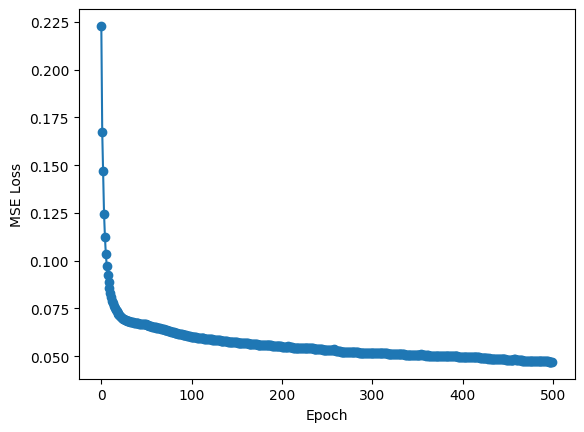

In [28]:
# Plot training loss
plt.figure()
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Inference & AUC

In [29]:
model.eval()
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Testing', leave=False):
        x = x.to(DEVICE)
        err = ((x - model(x))**2).mean(dim=1).cpu().numpy()
        scores.extend(err)
        labels.extend(y.numpy())
auc = roc_auc_score(labels, scores)
print('AUC:', auc)


AUC: 0.7054431960049938


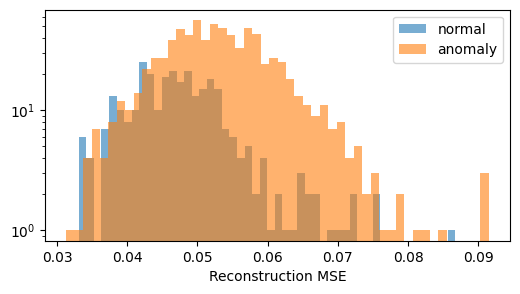

In [30]:
# Error distribution
normal_err = [s for s,l in zip(scores,labels) if l==0]
anom_err   = [s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(normal_err, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom_err,   bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction MSE')
plt.legend()
plt.show()
